# NBA : Why Isn't My Team making the Playoffs?

# Gathering Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Seaborn
import seaborn as sns
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

#Plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
#Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()


### Dataset was imported from Kaggle and was already in train_test_split so I remade the original 

In [2]:
nba_train = pd.read_csv('NBA_train.csv')

In [3]:
nba_test =pd.read_csv('NBA_test.csv')

In [4]:
nba = pd.concat([nba_train,nba_test])
nba = nba.reset_index(drop=True)


# pd.set_option('display.max_rows', 1000) | if needed to display full df
# plt.xticks(rotation=90); | if need to rotate labels

### *What is the magic number to make the dance?*
- What is the avg number of wins for a playoff team?

In [5]:
#New DataFrame with only playoff teams
nba_playoffs = nba[nba['Playoffs']==1]



# Exploratory Data Analysis: Determine How to Get Wins

## New  Features
- 2pt % (make/attempts)
- 3pt% (make/attempts)
- FT %(make/attempts)
- RB Ratio (offensive/defensive)
- Assist to PTS (assits/pts)
- TO diff ((blk + stl)- TO) 
- Pt diff (pts-opp pts)

#### From the dataset I think these metrics will have the highest correlation to winning basketball games. Most of these are intuitive, but it will be interesting to see the numerical backed arguments for which is most impactful. I'm personlly most interested to see if the assist to points metric has any weight for determining wins. 

In [6]:
#Calculating Metrics into new Columns
nba['2P%'] = nba['2P']/nba['2PA']*100
nba['3P%'] = nba['3P']/nba['3PA']*100
nba['FT%'] = nba['FT']/nba['FTA']*100
nba['AST%'] = nba['AST']/nba['PTS']*100
nba['ORB%'] = nba['ORB']/nba['DRB']*100
nba['TO_DIFF'] = (nba['BLK']+nba['STL'])-nba['TOV']
nba['PTS_DIFF'] = nba['PTS']-nba['oppPTS']


In [7]:
#Creating New Dataset to analyis metrics
nba_feat=nba[['Playoffs', 'W','2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']]
x_feat=['2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']
nba_feat.head()

,Playoffs,W,2P%,3P%,FT%,AST%,ORB%,TO_DIFF,PTS_DIFF
0,1,50,46.720368,17.333333,77.051040,22.314242,56.899418,-174,239
1,1,61,49.605169,38.388626,77.868518,23.626787,49.938950,-422,639
2,0,30,49.370126,25.454545,77.893519,24.418473,45.233266,-588,-222
3,0,37,48.064680,19.251337,77.188209,22.521368,54.892902,-264,28
4,0,30,46.832987,32.549020,73.690429,23.417436,51.941363,-383,-362


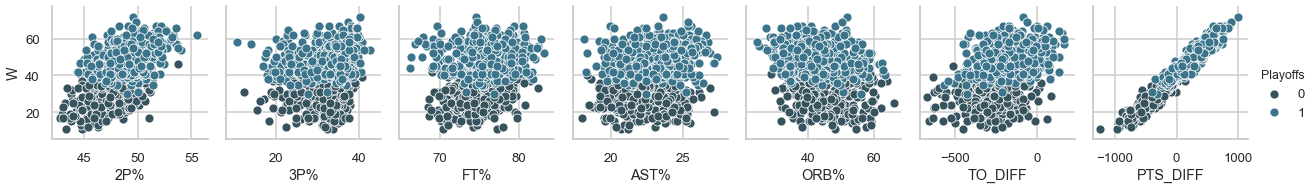

In [8]:
sns.set_context('talk',font_scale=.8)
sns.pairplot(data=nba_feat,y_vars=['W'],x_vars=x_feat,hue='Playoffs');

## Training and Testing Data

I set a variable X equal to the new numerical features and Y equal to the Wins.

In [9]:
#split by .25 so trainand test sets are full seasons (24 train, 8 test, 32 total)
nba['SeasonEnd'].nunique()


32

In [10]:
X = nba_feat[[ '2P%', '3P%', 'FT%', 'AST%', 'ORB%', 'TO_DIFF','PTS_DIFF']]
y = nba_feat['Playoffs']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)

## Training the Model

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
rfc_pred = rfc.predict(X_test)

## Evaluation

In [14]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,rfc_pred))

[[ 86  11]
 [  7 112]]


In [15]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91        97
           1       0.91      0.94      0.93       119

    accuracy                           0.92       216
   macro avg       0.92      0.91      0.92       216
weighted avg       0.92      0.92      0.92       216



# Model Predicted 92% of Teams correctly based on NBA_Feat DataFrame